# 0. Objetivos:

### O que é Term Deposit / Depósito a Prazo Fixo?


Um depósito a prazo fixo é uma ferramenta de poupança na qual o dinheiro é depositado em uma conta em uma instituição financeira. Os investimentos em depósitos a prazo geralmente têm vencimentos de curto prazo, que variam de um mês a alguns anos, têm níveis variados de depósitos mínimos exigidos e pagam uma taxa de juros fixa ao investidor.

| Variable Name | Papel | Tipo | Demográfico | Descrição | Unidades | Ausentes |
|---------------|-------|------|-------------|-----------|----------|----------|
| idade | Atributo | Inteiro | Idade |  |  | não |
| trabalho | Atributo | Categórico | Ocupação | tipo de emprego (categórico:  'administrativo', 'operário', 'empresário', 'doméstica', 'gerência','aposentado', 'autônomo', 'serviços', 'estudante', 'técnico', 'desempregado','desconhecido') |  | não |
| estado_civil | Atributo | Categórico | Estado Civil | estado civil (categórico: 'divorciado', 'casado', 'solteiro', 'desconhecido')  |  | não |
| escolaridade | Atributo | Categórico | Nível de Educação | (categórico: 'desconhecido', 'primário', 'secundário', 'superior') |  | não |
| inadimplente | Atributo | Binário |  | possui crédito em inadimplência? |  | não |
| saldo | Atributo | Inteiro |  | saldo médio anual | Euros | não |
| emp_habitacional | Atributo | Binário |  | possui empréstimo habitacional? |  | não |
| emp_pessoal | Atributo | Binário |  | possui empréstimo pessoal? |  | não |
| tipo_contato | Atributo | Categórico |  | tipo de comunicação de contato (categórico: 'celular','telefone', 'desconhecido) |  | sim |
| dia | Atributo | Data |  | último dia de contato da semana |  | não |
| mes | Atributo | Data |  | último mês de contato do ano (categórico: 'jan', 'fev', 'mar', ..., 'nov', 'dez') |  | não |
| tempo_chamada | Atributo | Inteiro |  | duração do último contato, em segundos (numérico).<br>Nota importante: este atributo afeta altamente o alvo de saída (ex.: se tempo_chamada=0 então y='no').<br>No entanto, a duração não é conhecida antes de uma chamada ser realizada.<br>Além disso, após o fim da chamada, y é obviamente conhecido.<br>Portanto, esta entrada deve ser incluída apenas para fins de benchmark e deve ser descartada se a intenção for ter um modelo preditivo realista. |  | não |
| campanha_atual | Atributo | Inteiro |  | número de contatos realizados durante esta campanha e para este cliente (numérico, inclui o último contato) |  | não |
| dias_prévios | Atributo | Inteiro |  | número de dias que se passaram após o cliente ter sido contatado pela última vez de uma campanha anterior (numérico; -1 significa que o cliente não foi contatado anteriormente) |  | sim |
| campanha_anterior | Atributo | Inteiro |  | número de contatos realizados antes desta campanha e para este cliente |  | não |
| res_campanha | Atributo | Categórico |  | resultado da campanha de marketing anterior (categórico: 'falha','inexistente','sucesso') |  | sim |
| deposito | Alvo | Binário |  | o cliente assinou um depósito a prazo? |  | não

## Caso de Negócio:
- Você é gerente de banco e deseja maximizar o Retorno sobre o Tempo Investido (ROTI) de um cliente que subscreve um depósito a prazo.
- Você, como analista de dados, deve descobrir quais características são mais valiosas para aumentar a retenção de dinheiro.

# 1. Início:

### Imports e inicialização:

In [1]:
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import IFrame

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from yellowbrick.classifier import ConfusionMatrix
from random import choice

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
bank_df = pd.read_csv("/content/bank.csv")
bank_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')

In [4]:
paleta_cores =  ['#005CA9', '#F39200', '#F9B000', '#00B5E5', '#EF765E', '#54BBAB', '#B26F9B', '#AFCA0B', '#004198', '#FFFFFF']

## 1.1 Tradução:

Para melhor visualização e leitura dos gráficos no PDF:

In [5]:
bank_df = bank_df.rename(columns ={'age': 'idade',
                          'job': 'trabalho',
                          'marital': 'estado_civil',
                          'education': 'escolaridade',
                          'default': 'inadimplente',
                          'balance': 'saldo',
                          'housing': 'emp_habitacional',
                          'loan': 'emp_pessoal',
                          'contact': 'tipo_contato',
                          'day': 'dia',
                          'month': 'mes',
                          'duration': 'tempo_chamada',
                          'campaign': 'campanha_atual',
                          'pdays': 'dias_prévios',
                          'previous': 'campanha_anterior',
                          'poutcome': 'res_campanha',
                          'deposit': 'deposito'})



In [6]:
bank_df['trabalho'] = bank_df['trabalho'].replace({'admin.': 'administrativo',
                                                   'blue-collar': 'operário',
                                                   'entrepreneur': 'empresário',
                                                   'housemaid': 'doméstica',
                                                   'management': 'gerência',
                                                   'retired': 'aposentado',
                                                   'self-employed': 'autônomo',
                                                   'services': 'serviços',
                                                   'student': 'estudante',
                                                   'technician': 'técnico',
                                                   'unemployed': 'desempregado',
                                                   'unknown': 'desconhecido'})

bank_df['estado_civil'] = bank_df['estado_civil'].replace({'divorced': 'divorciado',
                                                           'married': 'casado',
                                                           'single': 'solteiro',
                                                           'unknown': 'desconhecido'})

bank_df['escolaridade'] = bank_df['escolaridade'].replace({'unknown': 'desconhecido',
                                                           'primary': 'primário',
                                                           'secondary': 'secundário',
                                                           'tertiary': 'superior'})

bank_df['inadimplente'] = bank_df['inadimplente'].replace({'yes': 'sim',
                                                           'no': 'não',
                                                           'unknown': 'desconhecido'})

bank_df['emp_habitacional'] = bank_df['emp_habitacional'].replace({'yes': 'sim',
                                                                   'no': 'não'})

bank_df['emp_pessoal'] = bank_df['emp_pessoal'].replace({'yes': 'sim',
                                                         'no': 'não'})

bank_df['tipo_contato'] = bank_df['tipo_contato'].replace({'cellular': 'celular',
                                                           'telephone': 'telefone',
                                                           'unknown': 'desconhecido'})

bank_df['mes'] = bank_df['mes'].replace({'jan': 'jan',
                                         'feb': 'fev',
                                         'mar': 'mar',
                                         'apr': 'abr',
                                         'may': 'mai',
                                         'jun': 'jun',
                                         'jul': 'jul',
                                         'aug': 'ago',
                                         'sep': 'set',
                                         'oct': 'out',
                                         'nov': 'nov',
                                         'dec': 'dez'})

bank_df['res_campanha'] = bank_df['res_campanha'].replace({'failure': 'falha',
                                                           'nonexistent': 'inexistente',
                                                           'success': 'sucesso'})

bank_df['deposito'] = bank_df['deposito'].replace({'yes': 'sim',
                                                    'no': 'não'})


## 1.2 Informações:

In [7]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   idade              11162 non-null  int64 
 1   trabalho           11162 non-null  object
 2   estado_civil       11162 non-null  object
 3   escolaridade       11162 non-null  object
 4   inadimplente       11162 non-null  object
 5   saldo              11162 non-null  int64 
 6   emp_habitacional   11162 non-null  object
 7   emp_pessoal        11162 non-null  object
 8   tipo_contato       11162 non-null  object
 9   dia                11162 non-null  int64 
 10  mes                11162 non-null  object
 11  tempo_chamada      11162 non-null  int64 
 12  campanha_atual     11162 non-null  int64 
 13  dias_prévios       11162 non-null  int64 
 14  campanha_anterior  11162 non-null  int64 
 15  res_campanha       11162 non-null  object
 16  deposito           11162 non-null  objec

In [8]:
bank_df.head(3)

,idade,trabalho,estado_civil,escolaridade,inadimplente,saldo,emp_habitacional,emp_pessoal,tipo_contato,dia,mes,tempo_chamada,campanha_atual,dias_prévios,campanha_anterior,res_campanha,deposito
0,59,administrativo,casado,secundário,não,2343,sim,não,desconhecido,5,mai,1042,1,-1,0,unknown,sim
1,56,administrativo,casado,secundário,não,45,não,não,desconhecido,5,mai,1467,1,-1,0,unknown,sim
2,41,técnico,casado,secundário,não,1270,sim,não,desconhecido,5,mai,1389,1,-1,0,unknown,sim


# 2. Análise Exploratória:

### 2.1 Distribuição de Variáveis:

#### 2.1.1 Numéricas:

In [9]:
fig = px.histogram(bank_df, x="idade", color="deposito", color_discrete_map={'não': paleta_cores[0],
                                                                             'sim': paleta_cores[1]})
fig.update_layout(title = dict(text='Relação da variável Idade com Depósito'), width= 750, height=600, xaxis_title='Idade', yaxis_title='Frequência')
fig.show()

In [10]:
fig = px.histogram(bank_df, x="saldo", color="deposito", nbins = 100, color_discrete_map={'não': paleta_cores[0],
                                                                                          'sim': paleta_cores[1]})
fig.update_layout(title = dict(text='Relação da variável Saldo com Depósito'), width= 750, height=600, xaxis_title='Saldo', yaxis_title='Frequência')
fig.show()

In [11]:
bank_df[['idade', 'saldo']].describe().T

,count,mean,std,min,25%,50%,75%,max
idade,11162.0,41.231948,11.913369,18.0,32.0,39.0,49.0,95.0
saldo,11162.0,1528.538524,3225.413326,-6847.0,122.0,550.0,1708.0,81204.0


In [12]:
bank_df[['idade', 'saldo']].corr()

,idade,saldo
idade,1.0000,0.1123
saldo,0.1123,1.0000


#### 2.1.2 Binárias e Categóricas:

In [13]:
# Variável dependente 'deposit:

bank_df.deposito.value_counts().reset_index()

,deposito,count
0,não,5873
1,sim,5289


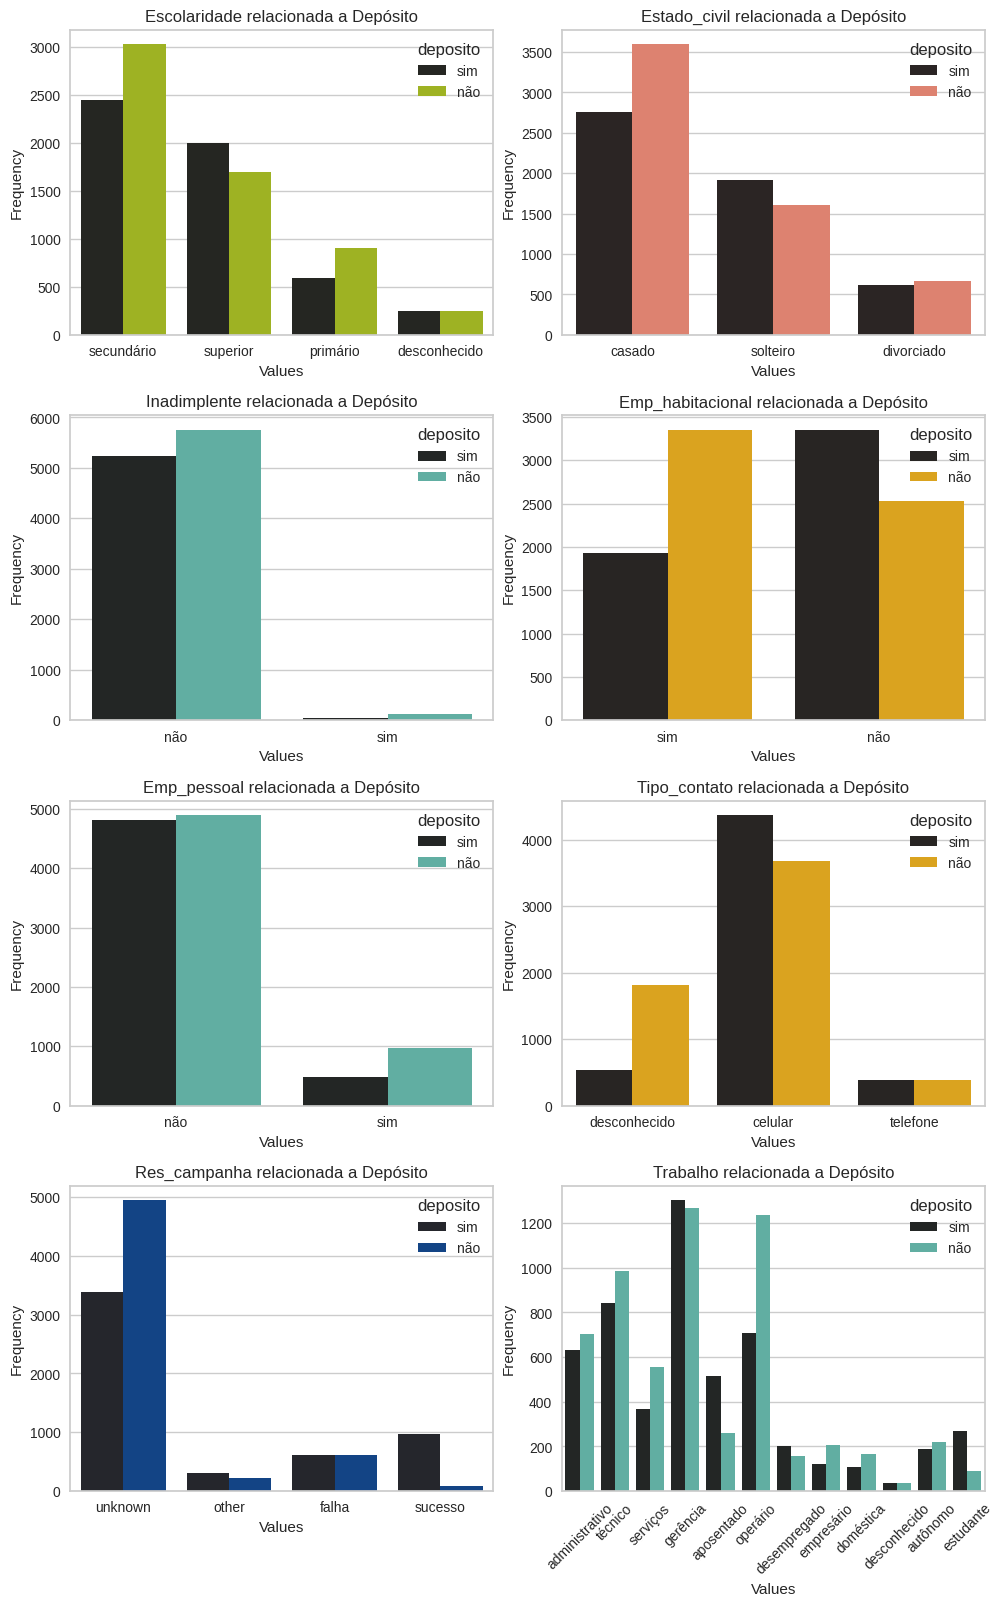

In [14]:
#  Construção do layout para o display dos gráficos:

cols = ['escolaridade', 'estado_civil', 'inadimplente', 'emp_habitacional',
       'emp_pessoal', 'tipo_contato', 'res_campanha','trabalho']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 16))
f_axes = axes.flatten()

# Gráficos para as variáveis independentes:
def plot_count(ds, ax, col, color):

  fig = sns.countplot(ds, x=col, hue='deposito', ax=ax, color=color)
  fig.set_xlabel('Values')
  fig.set_ylabel('Frequency')
  fig.set_title(f'{col.capitalize()} relacionada a Depósito')
  plt.xticks(rotation=45, ha='center')

for index, cols in enumerate(cols):

    plot_count(bank_df, f_axes[index], col=cols, color=choice(paleta_cores[1:-1]))


plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

### 2.2 Análises das colunas temporais:

In [15]:
print(bank_df.mes.unique())

deposits_by_month = pd.DataFrame(bank_df[['mes', 'deposito']].groupby('mes').value_counts(normalize=True).reset_index())
deposits_by_month = deposits_by_month.sort_values(by=['deposito','proportion'], ascending=True)
deposits_by_month = deposits_by_month.rename(columns={'proportion': 'proporção'})
deposits_by_month.head(12)

['mai' 'jun' 'jul' 'ago' 'out' 'nov' 'dez' 'jan' 'fev' 'mar' 'abr' 'set']


,mes,deposito,proporção
5,dez,não,0.090909
17,mar,não,0.101449
23,set,não,0.156740
21,out,não,0.176020
1,abr,não,0.374865
7,fev,não,0.431701
2,ago,não,0.547070
12,jun,não,0.553191
18,nov,não,0.572641
10,jul,não,0.585865


In [16]:
deposits_by_day = pd.DataFrame(bank_df[['dia', 'deposito']].groupby('dia').value_counts(normalize=True).reset_index())
deposits_by_day = deposits_by_day.sort_values(by=['deposito','proportion'], ascending=True)
deposits_by_day = deposits_by_day.rename(columns={'proportion': 'proporção'})
deposits_by_day.head(10)

,dia,deposito,proporção
19,10,não,0.257669
1,1,não,0.262295
49,25,não,0.406250
5,3,não,0.418301
43,22,não,0.427509
7,4,não,0.427861
59,30,não,0.433054
23,12,não,0.451685
3,2,não,0.455090
25,13,não,0.467991


As proporções de quantos clientes não depositam em relação ao total de um dia ou mês são aleatórias, com alguns meses com maior captação de depósito que outros.

### 2.3 Valores para fins de análise descritiva e benchmark:

> Essas variáveis ​​são principalmente para fins de desempenho e benchmark e não são adequadas para um modelo de classificação

> Podemos verificar observando métricas como variância e correlação.

In [17]:
vars = ['dia', 'tempo_chamada', 'campanha_atual', 'dias_prévios','campanha_anterior', 'deposito']

In [18]:
bank_df.columns

Index(['idade', 'trabalho', 'estado_civil', 'escolaridade', 'inadimplente',
       'saldo', 'emp_habitacional', 'emp_pessoal', 'tipo_contato', 'dia',
       'mes', 'tempo_chamada', 'campanha_atual', 'dias_prévios',
       'campanha_anterior', 'res_campanha', 'deposito'],
      dtype='object')

In [19]:
bank_df[vars[:-1]].describe()

,dia,tempo_chamada,campanha_atual,dias_prévios,campanha_anterior
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,15.658036,371.993818,2.508421,51.330407,0.832557
std,8.420740,347.128386,2.722077,108.758282,2.292007
min,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,22.000000,496.000000,3.000000,20.750000,1.000000
max,31.000000,3881.000000,63.000000,854.000000,58.000000


In [20]:

bank_df[vars[1:-1]] = bank_df[vars[1:-1]].astype(float)

fig = make_subplots(rows=2, cols=2, subplot_titles=vars[1:-1], vertical_spacing=0.15, horizontal_spacing=0.15)

for i, var in enumerate(vars[1:-1]):
    row = (i // 2) + 1 # [1, 1, 2, 2]
    col = (i % 2) + 1 # [1, 2, 1, 2]

    box_fig = px.box(bank_df, x='deposito', y=var, color='deposito')

    for trace in box_fig.data:
        fig.add_trace(trace, row=row, col=col)

    fig.update_xaxes(title_text='Depósito', row=row, col=col)
    fig.update_yaxes(title_text='Valores', row=row, col=col)

fig.update_layout(title=dict(text='Boxplots para variáveis relacionadas à campanha e ao atendimento de clientes'), height=800, width= 750)

fig.show()

In [21]:
bank_df.deposito = bank_df.deposito.replace({'não': 0, 'sim': 1}).astype(int)

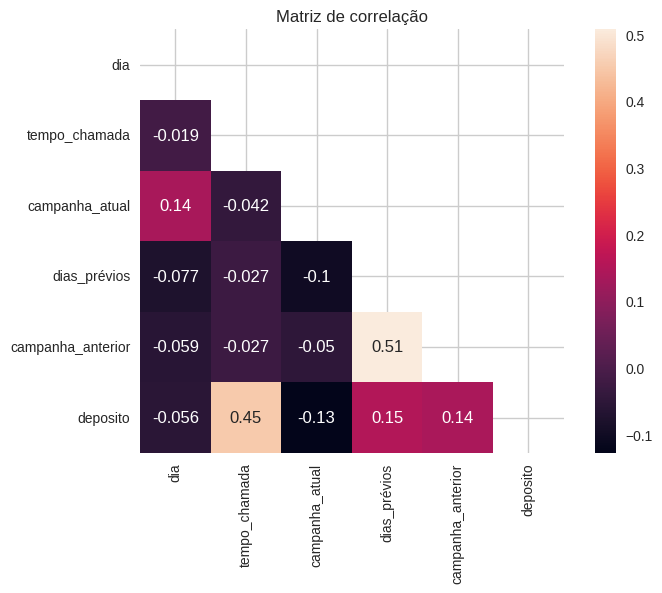

In [22]:
corr = bank_df[vars].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, annot=True, mask=mask, square=True, linewidths=0);
plt.title('Matriz de correlação');

# 3. Modelo:

Escolhi o CatBoost para análise da importância das variáveis para o cliente efetivar o depósito pelas seguintes razões:



1.   Muitas variáveis categóricas nominas e ordinais (não necessito fazer o encoding manual).
2.   Outliers presentes na variável 'saldo' (algoritmos de boosting são robustos contra outliers).
3.   Facilidade de conseguir os coeficientes.



## 3.1 Seleção das variáveis:

In [23]:
# I've removed other columns because either they have little to no correlation or may have bias.

vars = ['idade', 'trabalho', 'estado_civil', 'escolaridade', 'saldo', 'emp_habitacional',
       'emp_pessoal', 'tipo_contato', 'deposito']

cat_vars = ['trabalho','estado_civil', 'escolaridade', 'emp_habitacional','emp_pessoal', 'tipo_contato']

In [24]:
bank_df[vars].dtypes

,0
idade,int64
trabalho,object
estado_civil,object
escolaridade,object
saldo,int64
emp_habitacional,object
emp_pessoal,object
tipo_contato,object
deposito,int64


In [25]:
X = bank_df[vars].iloc[:, :-1]

y = bank_df['deposito']

## 3.2 Modelo:

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    shuffle=True)

model = CatBoostClassifier(iterations=600,
                           learning_rate=1.0,
                           depth=8,
                           eval_metric='Accuracy',
                           verbose=200)

model.fit(X_train, y_train, cat_features=cat_vars)

0:	learn: 0.6551189	total: 91.1ms	remaining: 54.5s
200:	learn: 0.9516187	total: 8.46s	remaining: 16.8s
400:	learn: 0.9955800	total: 15.7s	remaining: 7.82s
599:	learn: 0.9997611	total: 18.9s	remaining: 0us


## 3.3 Resultados:

In [27]:
predictions = model.predict(X_test)

accuracy_score(y_test, predictions)

0.641347187388033

In [28]:
confusion_matrix(y_test, predictions, labels =[0, 1])

array([[991, 459],
       [542, 799]])

/usr/local/lib/python3.12/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning:

could not determine class_counts_ from previously fitted classifier



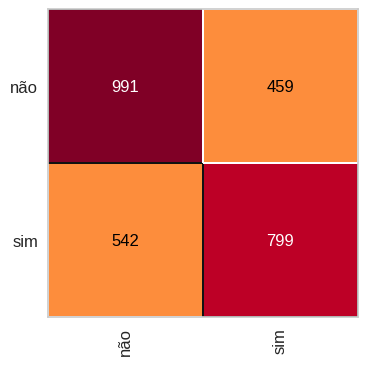

In [29]:
plt.subplots(figsize=(4,4))
from yellowbrick.contrib.wrapper import classifier
cm_model = classifier(model)
cm = ConfusionMatrix(cm_model, classes=['não', 'sim'])
cm.score(X_test, y_test);

In [30]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.65      0.68      0.66      1450
           1       0.64      0.60      0.61      1341

    accuracy                           0.64      2791
   macro avg       0.64      0.64      0.64      2791
weighted avg       0.64      0.64      0.64      2791



## 3.4 Importâncias das variáveis:

In [31]:
print(vars[:-1])

importance = model.get_feature_importance(type='PredictionValuesChange')
importance

['idade', 'trabalho', 'estado_civil', 'escolaridade', 'saldo', 'emp_habitacional', 'emp_pessoal', 'tipo_contato']


array([19.82466326, 20.95491065,  9.83946286, 10.19107161, 23.55614458,
        5.82528475,  2.48252614,  7.32593616])

In [32]:
importance_df = pd.DataFrame({
    'features': vars[:-1],
    'importance': importance
}).sort_values(by='importance', ascending=False)

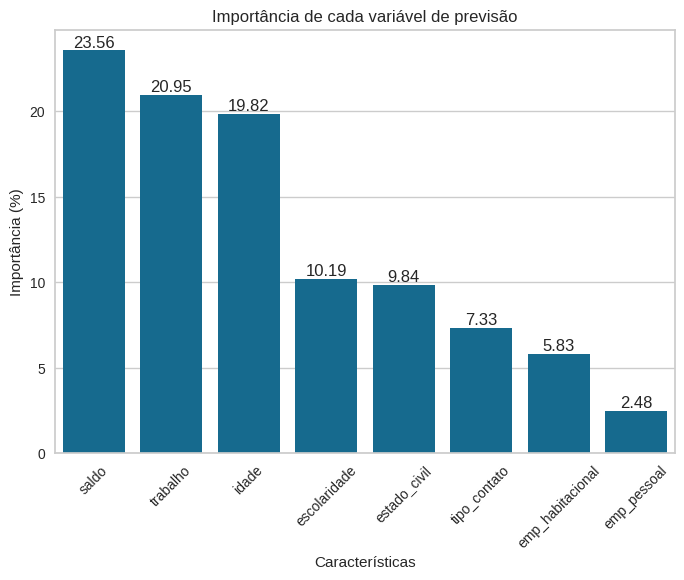

In [33]:
fig =sns.barplot(importance_df, x='features', y='importance')

for container in fig.containers:
    fig.bar_label(container, fmt='%.2f', label_type='edge')

fig.set_xlabel('Características')
fig.set_ylabel('Importância (%)')

plt.title("Importância de cada variável de previsão");
plt.xticks(rotation=45, ha='center')

plt.show()


# 4. Conclusão:

1. Os perfis de clientes mais amplos que o banco possui são de jovens ou idosos, com um bom capital guardado e sem empréstimo habitacional.  ​

2. Efetiva-se ou não boa parte dos contratos através do primeiro contato com ​o cliente.​

3. Descobrindo a idade, trabalho e saldo financeiro do cliente, conseguimos obter​ uma boa estimativa acerca da possibilidade do cliente investir através do banco.